<a href="https://colab.research.google.com/github/DylanLoader/Statistics-600-seminar/blob/master/stat_600_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Google Colab
## Author: Dylan Loader



---



---



## What is Google Colaboratory?

- A free google based notebook with R, Python, and Markdown support
- Google Drive Integration
- Comes with a large number of pre-installed packages
- Access to Graphics Processing Units (GPUs) and Tensor Processing Units (TPUs)
- Easy error handling with Stackoverflow integration
- Connectivity with cloud resources such as Google Cloud


# The MNIST Handwritten Dataset

---

- The MNIST dataset consists of 70,000 black and white images of handwritten digits provided by Dr. Yann LeCun
- The images are available as 28x28 pixel images (usually represented as 28x28x1 vector)

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Source: https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png

# A 5-10 minute Crash Course in Convolutional Neural Nets (CNNs)

---


## Motivation for CNNs over NN

- Good for sequentially related data (images/audio/text)
- Ease of computing relative to large Neural Networks
- Frequently used in Computer Vision
- Generalize better to data that is distrorted such as rotations and blur



#### Ex. Labradoodle vs. Fried Chicken

![](https://pbs.twimg.com/media/DCIdebqW0AAIxm6?format=jpg&name=small)

Source: https://twitter.com/teenybiscuit

## CNN Layers
---

### Example Diagram
![An Example CNN](https://miro.medium.com/max/2055/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)



### Convolution Layers

- The convolution operation in a CNN is similar to the mathematical convolution of two functions to create a third function.



- In the case of our image recognition we use a filter(blue) generated from a uniform distribution centered at 0. The purple image is the feature map. 



![](https://stanford.edu/~shervine/images/convolution-layer-a.png)

Source:http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/

### Activation Functions

After each convolution an activation function is applied to elements of the matrix for two reasons:

1. Introduce non-linearity into our model

2. Improve computation time due the removal of negative floating point numbers

Ex. 

![](https://www.embedded-vision.com/sites/default/files/technical-articles/CadenceCNN/Figure8.jpg)

Source: https://www.embedded-vision.com/platinum-members/cadence/embedded-vision-training/documents/pages/neuralnetworksimagerecognition

### Pooling Layers

Pooling layers have two main benefits:

1. Reduce computation time by reducing size of layers in the network.

2. Preserves the detected features.

![](https://stanford.edu/~shervine/images/max-pooling-a.png)


### Drop-out Layers

- Commonly used in fully connected networks to prevent overfitting and to improve computation time.

- Often replaced by weight decay in Deep Networks.

### Fully Connected Layers

- After convolution and pooling layers the current weights are flattened and passed through a fully connected layer.

- Usually after the fully connected layers we apply a high rate of dropout (in this case 50%) and pass the remaining values to an output activation function.

![](https://stanford.edu/~shervine/images/fully-connected.png)



Source: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks#layer

### Output Layer (Softmax)

- One of the most common output activation functions is softmax. 
- It is approximately a generalization of the logistic classifier

Let $x \in \mathbb{R}^k$. The softmax function is defined as: 

$$\vec{p}=\begin{pmatrix} p_1\\ .\\ .\\ .\\ p_k\end{pmatrix};
p_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$


# CNN Training In Browser

---

## Google Colab has Custom Package Installation

In [1]:
# Install non-native packages
!pip install keras-tqdm
!pip install pillow

## Google Colab has Several Pre-installed Packages

Here we import Keras, SKlearn, and TensorFlow all without having to go through all the time consuming local installation. 


In [2]:
# Source of original: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
# This notebook is modified to run by fetching data from openml instead of csv

# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from PIL import Image
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.14.0


Using TensorFlow backend.


## Verify That We're Using Our TPU or GPU

![]('../hosted-runtime.PNG')









In [3]:
# Detect TPU, GPU, or CPU hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /job:localhost/replica:0/task:0/device:GPU:0
Number of accelerators:  1


## Let's Get to (Machine) Learning

In [0]:
# Load the MNIST data from openml
X,y = fetch_openml('mnist_784', version=1, cache=True,return_X_y=True) # Pull the mnist dataset

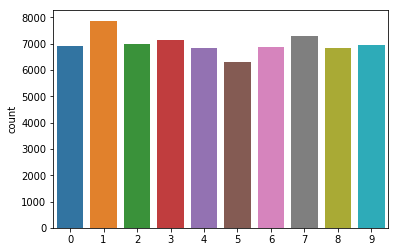

In [5]:
# Check distribution before subsampling
y_num = y.astype('int64')
sns.countplot(y_num)

## Data Subsetting
---

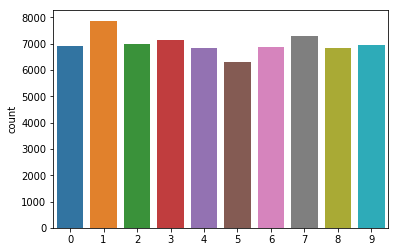

In [6]:
# Subset the data so we get training in some reasonable time for presentation
X_sub, y_sub = X[:70000],y[:70000]

# Check to see that there's no crazy imbalance caused by subsetting
sns.countplot(y_sub)

In [0]:
# Set the subsets to the original variable names
X = X_sub
y = y_sub

In [8]:
print(f'x shape: {X.shape},\ny shape: {y.shape}')

x shape: (70000, 784),
y shape: (70000,)


## Data Transformation

Here we rescale the data to the range [0,1] to improve the convergence properties of the learning process.

In [0]:
# Normalize the data
X_norm = preprocessing.normalize(X)

In [0]:
# Split the training and test sets
y = to_categorical(y,num_classes=10)
X_train, X_test, y_train, y_test = train_test_split(X_norm,y,
                                                    test_size = 0.25,
                                                    random_state=1775)
assert(X_train.shape[0]+X_test.shape[0] == X.shape[0]) # Checks that the split was successful

In [0]:
# Reshape the 1D vectors (length 784) from mnist into matricies (tensor)
X_train = X_train.reshape(-1,28,28,1) 
X_test = X_test.reshape(-1,28,28,1)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

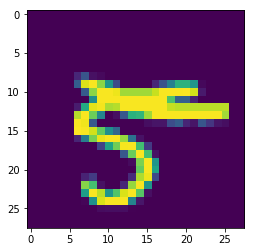

In [121]:
# Check the image plot of the stored training data
g = plt.imshow(X_train[0][:,:,0])
y_train[0]

## Keras Model Definition

In [0]:
# Build the model framework
model = None # Clear model object
model = Sequential()
model.add(Conv2D(filters=32,
                 kernel_size=(5,5), 
                 padding = 'Same',
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding = 'Same',
                 activation='relu'))
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),
                    strides=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

In [116]:
model.summary() # Check that the model is defined correctly

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)         

In [0]:
optimizer = RMSprop(lr=0.001,
                    rho=0.9,
                    epsilon=1e-08,
                    decay=0.0)

In [0]:
# Model compilation
model.compile(optimizer=optimizer, 
              loss = 'categorical_crossentropy',
              metrics=["accuracy"])

In [0]:
# Set number of epochs to run, generally more epochs gives higher accuracy
epochs = 5 # Number of passes through the complete dataset
batch_size = 64 # Number of training data to iterate through before updating params

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Model Training

In [120]:
# model fitting
history =  model.fit(X_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data = (X_test,y_test),verbose=2, 
                     callbacks=[learning_rate_reduction,TQDMNotebookCallback()])

Train on 52500 samples, validate on 17500 samples


Epoch 1/5


 - 8s - loss: 0.2162 - acc: 0.9312 - val_loss: 0.0562 - val_acc: 0.9814
Epoch 2/5


 - 7s - loss: 0.0720 - acc: 0.9779 - val_loss: 0.0411 - val_acc: 0.9870
Epoch 3/5


 - 7s - loss: 0.0562 - acc: 0.9842 - val_loss: 0.0410 - val_acc: 0.9878
Epoch 4/5


 - 7s - loss: 0.0474 - acc: 0.9866 - val_loss: 0.0358 - val_acc: 0.9883
Epoch 5/5


 - 7s - loss: 0.0430 - acc: 0.9879 - val_loss: 0.0374 - val_acc: 0.9893



In [0]:
from PIL import Image
import glob
image_list = []
int_list = []
for filename in glob.glob('/content/*.png'): #assuming gif
    im=Image.open(filename).convert('L')
    tail_string = filename.strip('/content/img-')
    numeric_string = int(tail_string.strip('.p'))
    int_list.append(numeric_string)
    image_list.append(im)

In [112]:
for counter,img in enumerate(image_list):
  display((img))

In [0]:
predict_list = []
for i in image_list:
  pred = model.predict(preprocessing.normalize((np.array(i))).reshape(-1,28,28,1))
  predict_list.append(pred.argmax())
# str(model.predict_classes(np.array(image_list[0]).reshape(-1,28,28,1)))

In [114]:
predict_list

[5, 1, 8, 7, 6, 9, 2, 4, 3, 8]

In [67]:
model.predict_classes(np.array(image_list[0]).reshape(-1,28,28,1))

array([5])

In [0]:
X_train[0][:,:,0].reshape(-1,28,28,1).shape

(1, 28, 28, 1)

# References

* Deep Learning - Goodfellow-et-al-2016

* http://cs231n.github.io/convolutional-networks/

* https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

* https://www.kaggle.com/wrecked22/digit-recognizer-99-accuracy-using-cnn
